In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
% matplotlib inline
import math
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import time

# I The framework

Let $x$ be a test point. $\{x_i\}$_{i=1}^l are the "train" data. $\{V^k\}_{k=1}^l$ are the eigeinvectors of the covariance matrix $\bar{\mathbf{C}}$. If we suppose the $\Phi$-images of the train data to be centered (in the feature space), the covariance matrix is $\bar{\mathbf{C}}=\frac{1}{l}\sum_{k=1}^l\Phi(x_k)\Phi(x_k)^T$, so an eigenvector $V$ with eigenvalue $\lambda$ satisfies 
$\bar{\mathbf{C}}V=\lambda V$, 
i.e $\frac{1}{l}\sum_{k=1}^l(\Phi(x_k)\Phi(x_k)^T)V=\lambda V$, 
i.e $\frac{1}{l}\sum_{k=1}^l\underbrace{(\Phi(x_k)\cdot V)}_{scalar}\Phi(x_k)=\lambda V$
For non-zero eigenvalue $\lambda$ we have:
$V=\frac{1}{l\lambda}\sum_{k=1}^l\underbrace{(\Phi(x_k)\cdot V)}_{scalar}\Phi(x_k)$
So $V$ is a linear combination of the $\Phi$-images of the training data, there exist coefficients $\{\alpha_i\}_{i=1}^l$ such that $V=\sum_{i=1}^l\alpha_i \Phi(x_i)$. Now let's see how to actually compute these coefficients $\alpha_i$. The equation $\lambda V=\bar{\mathbf{C}}V$ can be written in $l$ scalar equations 
$$\forall j \in \{1,\dots,l\} \lambda(V \cdot \Phi(x_j))=(\bar{\mathbf{C}}V\cdot \Phi(x_j))$$
$$\lambda (\sum_{i=1}^l\alpha_i\Phi(x_i) \cdot \Phi(x_j))=(\Big[\frac{1}{l}\sum_{k=1}^l(\Phi(x_k) \Phi(x_k)^T)\sum_{i=1}^l\alpha_i\Phi(x_i)\Big] \cdot \Phi(x_j))$$
$$\lambda (\sum_{i=1}^l\alpha_i\Phi(x_i) \cdot \Phi(x_j))=(\Big[\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_i\underbrace{(\Phi(x_k) \Phi(x_k)^T)\Phi(x_i)}_{(\Phi(x_k)\cdot \Phi(x_i))\Phi(x_k)}\Big] \cdot \Phi(x_j))$$
$$\lambda (\sum_{i=1}^l\alpha_i\Phi(x_i) \cdot \Phi(x_j))=(\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_i(\Phi(x_k)\cdot \Phi(x_i))\Phi(x_k) \cdot \Phi(x_j))$$
$$\lambda \sum_{i=1}^l\alpha_ik(x_i, x_j)=(\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_ik(x_i, x_k)\Phi(x_k) \cdot \Phi(x_j))$$
$$\lambda \sum_{i=1}^l\alpha_ik(x_i, x_j)=\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_ik(x_i, x_k)k(x_k, x_j)$$
$$\lambda \sum_{i=1}^l\alpha_iK_{ij}=\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_iK_{ik}K_{kj}$$
$$\lambda \sum_{i=1}^l\alpha_i\underbrace{K_{ij}}_{=K_{ji} \text{because K symmetric}}=\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_iK_{ik}K_{kj}$$
$$\lambda (K\alpha)_j = \frac{1}{l}\sum_{k=1}^l(K\alpha)_kK_{kj}$$
$$\lambda (K\alpha)_j = \frac{1}{l}(KK\alpha)_j$$
So in a vector form we have:
$$\lambda K\alpha = \frac{1}{l}K^2\alpha$$
$$l \lambda K \alpha = K^2 \alpha$$
$$l \lambda \alpha = K \alpha$$
So
* Projections of $x$ on the $V^k$: $\beta_k=\sum_{i=1}^l\alpha_i^kk(x,x_i)$

* The $\gamma_i$ can also be computed before starting the iterations.
* I add maxIters as a parameter to calcZ

In [129]:
def gaussianKernel(x, y, c):
    ''' Returns K(x,y) where K denotes gaussian kernel '''
    return math.exp(-(np.linalg.norm(x-y)**2) / c)

def createK(data, kernelFunction, c):
    ''' Returns K matrix containing inner products of the data using the kernel function 
        so that K_ij := (phi(x_i)*phi(x_j)) '''
    l = len(data)
    K = np.zeros((l,l))
    for col in range(l):
        for row in range(l):
            K[row][col] = kernelFunction(data[row],data[col], c)
    return K

def calcBetaK(alphaK, kernelFunction, data, x, c):
    ''' Returns the projection of x onto the eigenvector V_k '''
    betaK = 0
    for i,xi in enumerate(data):
        betaK += alphaK[i]*kernelFunction(xi,x,c)
    return betaK

def centerK(K):
    ''' Returns centered K matrix, see K. Murphy 14.43 '''
    l = len(K)
    Kcentered = np.zeros((l,l))
    for i in range(l):
        for j in range(l):
            Kcentered[i][j] = K[i][j] - np.mean(K[i]) + (np.sum(K)/l**2) - np.mean(K.T[j])
    return Kcentered

def normAlpha(alpha, lambdas):
    ''' Returns new alpha corresponding to normalized eigen vectors,
        so that lambda_k(a^k * a^k) = 1 '''
    for i,a in enumerate(alpha):
        a /= np.sqrt(lambdas[i])
    return alpha

def calcZ(alpha, data, x, kernelFunction, c,z0, maxIters):
    ''' Equation (10), returns pre-image z for single input datapoint x '''
    z = z0
    iters=0
    # calculate beta (does not change with each iteration)
    beta = [calcBetaK(aK, kernelFunction, data, x, c) for aK in alpha]
    # gamma does not change with each iteration neither
    gamma = [calcGammaIOpt(alpha, i, beta) * kernelFunction(z,xi,c) for i, xi in enumerate(data)]

    while iters < maxIters:
        numerator = 0
        denom = 0
        for i, xi in enumerate(data):
            #gammaI = calcGammaI(alpha, i, data, x, kernelFunction, c) * kernelFunction(z,xi,c)
            #gammaI = calcGammaIOpt(alpha, i, beta) * kernelFunction(z,xi,c)
            gammaI = gamma[i] * kernelFunction(z,xi,c)
            numerator += gammaI * xi
            denom += gammaI
        if denom != 0: # > 10**-12: #handling numerical instability
            z = numerator/denom
            iters +=1
        else:
            # print("instability", "z", z, "x", x, "numerator", numerator)
            iters =0
            z=z0 + np.random.multivariate_normal(np.zeros(z0.size),np.identity(z0.size))
            numerator = 0
            denom = 0
    return z

def calcGammaI(alpha, i, data, x, kernelFunction, c):
    ''' returns gamma_i = sum_{k=1}^n beta_k * alpha_i^k '''
    gammaI = 0
    alphaI = alpha.T[i]
    for k, alphaKI in enumerate(alphaI):
        gammaI += calcBetaK(alpha[k], kernelFunction, data, x, c) * alphaKI
    return gammaI

def calcGammaIOpt(alpha, i, beta):
    ''' returns gamma_i = sum_{k=1}^n beta_k * alpha_i^k '''
    gammaI = 0
    alphaI = alpha.T[i]
    for k, alphaKI in enumerate(alphaI):
        gammaI += beta[k] * alphaKI
    return gammaI

## II Eleven gaussians in $\mathbb{R}^{10}$
Dataset:
* we generated a data set from eleven Gaussians in $\mathbb{R}^{10}$ with "zero" mean and variance $\sigma^2$ in each component
* selecting from each source $100$ points as a training set and $33$ points for a test set 
* centers of the Gaussians randomly chosen in $[-1, 1]^{10}$

## 1) Let's start in $\mathbb{R}^2$

Generate some 2D data

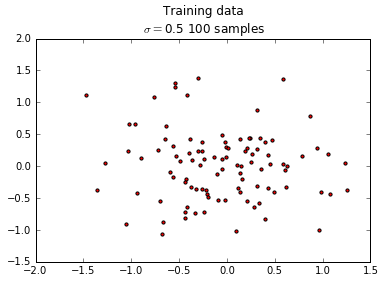

In [138]:
sigma = 0.5
center = np.array([0, 0])
Xtrain = np.random.multivariate_normal(center, sigma**2*np.identity(2), size=100)
Xtest = np.random.multivariate_normal(center, sigma**2*np.identity(2), size=33)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c="r", s=10)
plt.title("Training data\n $\sigma=$" + str(sigma) + " " + str(len(Xtrain)) + " samples")

## 2) Linear PCA

In [139]:
def error(Z, center):
    return np.mean(np.array([np.linalg.norm(z-center)**2 for z in Z]))

my implementation of linear PCA

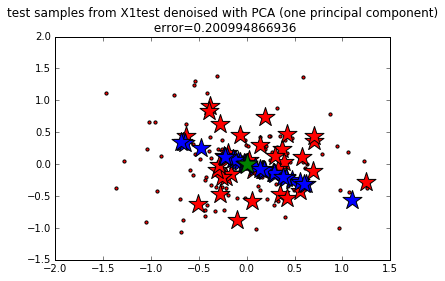

In [141]:
C = np.zeros((2, 2)) # covariance matrix of training samples
m = np.mean(Xtrain, axis=0) # mean of training samples
for x in Xtrain:
    C += 1/100*np.dot(np.reshape(x, (2, 1))-np.reshape(m, (2, 1)), 
                      (np.reshape(x, (2, 1))-np.reshape(m, (2, 1))).T)

lambda_, v = np.linalg.eigh(C)

Z = []
for x in Xtest:
    Z.append(np.sum([np.dot(x, vi)*vi for vi in v[-1:]], axis=0)) # use one component
Z = np.array(Z)

plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c="r", s=10, label="train data")
plt.scatter(Xtest[:, 0], Xtest[:, 1], c="r", marker="*", s=400, label="train data")
plt.scatter(Z[:, 0], Z[:, 1], c="b", marker="*", s=400, label="denoised")
# plt.scatter(Z2[:, 0], Z2[:, 1], c="b", marker="*", s=400, label="denoised")
plt.scatter(center[0], center[1], c="g", marker="*", s=500)
plt.title("test samples from X1test denoised with PCA (one principal component)\n error=" + str(error(Z, center)))

## 3) Kernel PCA

--- 4.960752964019775 seconds ---


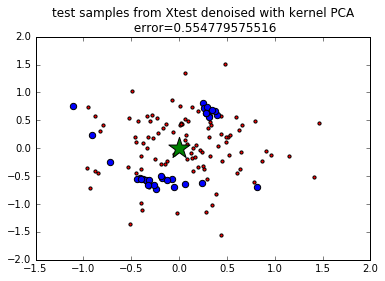

In [16]:
start_time = time.time()
c = 2*2*sigma**2
l = len(Xtrain)
maxIters = 50
n = 1

Data = Xtrain
K = centerK(createK(Data, gaussianKernel, c))

# find eigen vectors
lLambda, alpha = np.linalg.eigh(K) # (3), use eigh because K is symmetric, vap returned in increasing order
lambdas = lLambda/l # /l with the notation from the paper (but not murphys) 

# use only the n largest eigen values with corresponding vectors
lambdas=lambdas[-n:]
alpha=alpha[-n:]

# normalize alpha
alpha = normAlpha(alpha, lambdas)

Z =[]
for x in Xtest:
    Z.append(calcZ(alpha, Data, x, gaussianKernel, c, x, maxIters))
Z = np.array(Z)

plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c="r", s=10, label="train data")
plt.scatter(Z[:, 0], Z[:, 1], c="b", s=40, label="denoised")
plt.scatter(center[0], center[1], c="g", marker="*", s=500)
print("--- %s seconds ---" % (time.time() - start_time))
plt.title("test samples from Xtest denoised with kernel PCA\n error=" + str(error(Z, center)))

## 4) Pre-images from initialisation to convergence

some 2D data

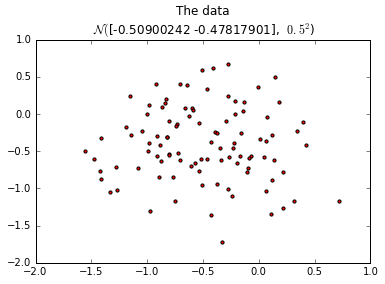

In [25]:
sigma = 0.5
center = np.random.uniform(-1, 1, size=2)
Xtrain = np.random.multivariate_normal(center, sigma**2*np.identity(2), size=100)
Xtest = np.random.multivariate_normal(center, sigma**2*np.identity(2), size=33)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c="r", s=10)
plt.title("The data\n $\mathcal{N}($" + str(center) +  ",  $0.5^2$)")

Let's see how the sequence $z_t$ evolves. And also check if convergence is reached at the same point across different random starting points.

[[-0.26142970341042931, -0.0015065205508649113]]


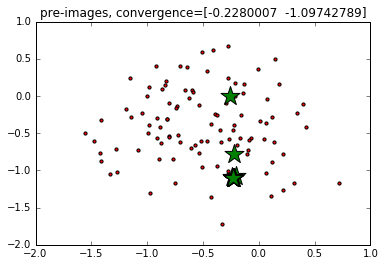

In [28]:
z = [list(np.random.multivariate_normal([0, 0], sigma**2*np.identity(2)))]
print(z) # the random starting point
n = 1 # one component for reconstruction
z0 = np.array([[0, 0]]) # in case of numerical instability
iters=0
maxIters = 30 # number of iterations
c = 2*2*sigma**2
Data = Xtrain
K = centerK(createK(Data, gaussianKernel, c))
lLambda, alpha = np.linalg.eigh(K) 
lambdas = lLambda/l 
lambdas=lambdas[-n:]
alpha=alpha[-n:]

# normalize alpha
alpha = normAlpha(alpha, lambdas)

beta = [calcBetaK(aK, gaussianKernel, Xtrain, x, c) for aK in alpha]
gamma = [calcGammaIOpt(alpha, i, beta) for i in range(len(Xtrain))]

while iters < maxIters:
    numerator = 0
    denom = 0
    for i, xi in enumerate(Xtrain):
        gammaI = gamma[i] * gaussianKernel(z[-1], xi, c)
        numerator += gammaI * xi
        denom += gammaI
    if denom!=0: #handling numerical instability
        z.append(numerator/denom)
        iters +=1
    else:
        print("---", "instability", denom, "---")
        iters = 0
        z = list(z0 + np.random.multivariate_normal(np.zeros(z0.size), np.identity(z0.size)))
        numerator = 0
        denom = 0
        
z = np.array(z)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c="r", s=10, label="the data")
plt.scatter(z[:, 0], z[:, 1], c="g", s=400, marker="*", label="z")
plt.title("pre-images, convergence=" + str(z[-1]))

## 3) Now the real thing in $\mathbb{R}^{10}$

Generate data in $\mathbb{R}^{10}$

In [135]:
sigma = np.array([0.05, 0.1, 0.2, 0.4, 0.8])
centers = np.random.uniform(-1, 1, size=(11, 10))
centers = np.zeros((11, 10))
Xtrain = np.array([[np.random.multivariate_normal(center, s**2*np.identity(10), size=100) for center in centers] for s in sigma])
Xtest = np.array([[np.random.multivariate_normal(center, s**2*np.identity(10), size=33) for center in centers] for s in sigma]) 
print(Xtrain.shape)

(5, 11, 100, 10)


In [136]:
maxIters = 10
def ratio(sigmaIdx, n):
    c = 10*2*sigma[sigmaIdx]**2
    errorKPCA, errorPCA = 0, 0
    for idx, center in enumerate(centers):
        Data = Xtrain[sigmaIdx][idx]
        Test = Xtest[sigmaIdx][idx]

        l = len(Data)

        # kernel pca
        K = centerK(createK(Data, gaussianKernel, c))
        lLambda, alpha = np.linalg.eigh(K) 
        lambdas = lLambda/l
        lambdas, alpha = lambdas[-n:], alpha[-n:]
        alpha = normAlpha(alpha, lambdas)

        #kpca = KernelPCA(n_components=n, kernel="rbf", fit_inverse_transform=True, gamma=10)
        #kpca.fit(Data)
        #Zkpca = kpca.transform(Test)

        # linear pca
        m = np.mean(Data, axis=0) # mean of training samples
        #pca = PCA(n_components=n)
        #pca.fit(Data)
        #Zpca2 = pca.transform(Test)
        #Zpca2 = np.array([m+np.sum(np.array([zz[i]*pca.components_[i] for i in range(n)])) for zz in Zpca2])

        C = np.zeros((10, 10)) # covariance matrix of training samples
        #print("mean of training samples", m, "center of generating gaussian", center)
        for x in Data-m:
            C += 1/100*np.dot(np.reshape(x, (10, 1)), np.reshape(x, (10, 1)).T)
        lambda_, v = np.linalg.eigh(C)

        Zkpca = []
        Zpca = []
        for x in Test:
            Zkpca.append(calcZ(alpha, Data, x, gaussianKernel, c, x, maxIters))
            Zpca.append(m+np.sum(np.array([np.dot(x, vi)*vi for vi in v[-n:]]), axis=0))
        Zkpca = np.array(Zkpca)
        Zpca = np.array(Zpca)
        #print("one sample of Zpca", Zpca[np.random.randint(0, len(Zpca)-1)])
        #print("one sample of Zkpca", Zkpca[np.random.randint(0, len(Zkpca)-1)])
        #print("-----------------------------------------------------------------")
        errorKPCA += error(Zkpca, center)
        errorPCA += error(Zpca, center)
    ratio = errorPCA/errorKPCA
    print(sigma[sigmaIdx], n, errorPCA, errorKPCA, ratio)
for n in range(1, 10):
    ratio(0, n)

0.05 1 0.0286502991524 0.19200016582 0.149220179212
0.05 2 0.0553966635534 0.118175171402 0.468767363705
0.05 3 0.0873151142443 0.0815414456396 1.07080655192
0.05 4 0.112687239853 0.0891887688913 1.2634689463
0.05 5 0.141961626842 0.0620700621958 2.28711913313
0.05 6 0.168977281615 0.0571661432322 2.95589788047
0.05 7 0.198464364809 0.0525109891737 3.77948250323
0.05 8 0.223280950688 0.0448559665496 4.97773134463
0.05 9 0.249728030731 0.0444138001082 5.6227575691


# III Half-circle 